In [180]:
import time

import numpy as np
import matplotlib.pyplot as plt
import utm

from planning_utils import a_star, heuristic
from planning_utils import create_grid as cg
from grid import create_grid
from udacidrone import Drone

from planning_utils import prune_path

%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 20

## Utils functions

In [181]:
def global_to_local(global_position, global_home):
    """
    Convert a global position (lon, lat, up) to a local position (north, east, down) relative to the home position.

    Returns:
        numpy array of the local position [north, east, down]
    """
    (east_home, north_home, _, _) = utm.from_latlon(global_home[1], global_home[0])
    (east, north, _, _) = utm.from_latlon(global_position[1], global_position[0])

    local_position = np.array([north - north_home, east - east_home, -global_position[2]])
    return local_position

In [182]:
def local_to_global(local_position, global_home):
    """
    Convert a local position (north, east, down) relative to the home position to a global position (lon, lat, up)

    Returns:
        numpy array of the global position [longitude, latitude, altitude]
    """
    (east_home, north_home, zone_number, zone_letter) = utm.from_latlon(global_home[1], global_home[0])
    (lat, lon) = utm.to_latlon(east_home + local_position[1], north_home + local_position[0], zone_number, zone_letter)

    lla = np.array([lon, lat, -local_position[2]])
    return lla

In [183]:
def heuristic_func(position, goal_position):
    return np.abs(position[0] - goal_position[0]) + np.abs(position[1] - goal_position[1])

In [184]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

In [185]:
# We're using collinearity here, but you could use Bresenham as well!
def prune_path(path):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        
        # If the 3 points are in a line remove
        # the 2nd point.
        # The 3rd point now becomes and 2nd point
        # and the check is redone with a new third point
        # on the next iteration.
        if collinearity_check(p1, p2, p3):
            # Something subtle here but we can mutate
            # `pruned_path` freely because the length
            # of the list is check on every iteration.
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

## Configuration values

In [196]:
# Static drone altitude (meters)
drone_altitude = 5.0

# Minimum distance stay away from obstacle (meters)
safe_distance = 5.0

start_ne = (10,  95)
goal_ne = (750., 370.)

## Compute the path from start to end

Found a path.


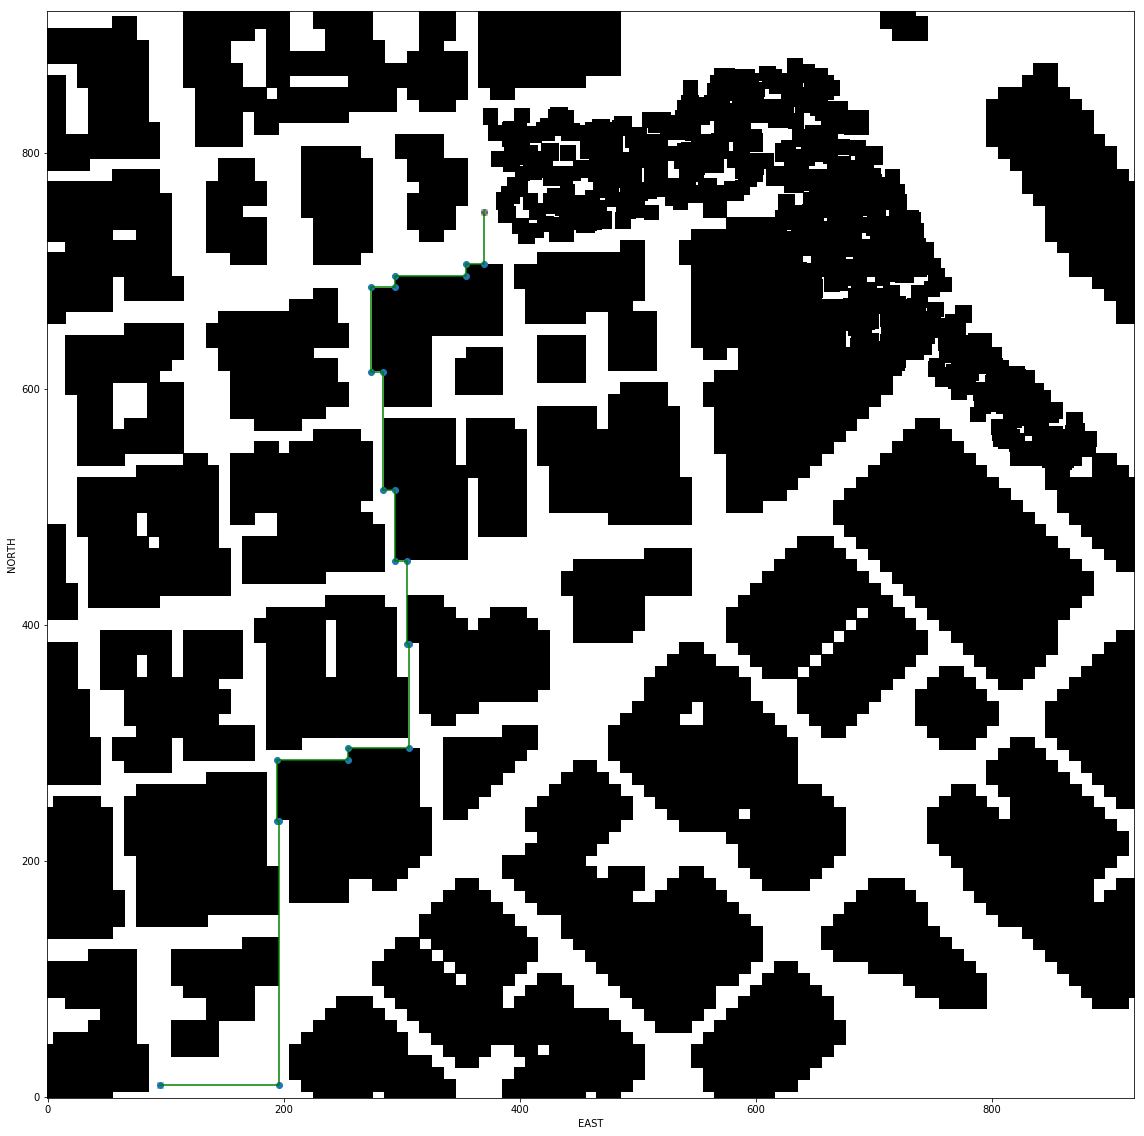

In [197]:
# Read all the values from obstacles in csv file;
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

grid = create_grid(data, drone_altitude, safe_distance)

path, cost = a_star(grid, heuristic_func, start_ne, goal_ne)

# Prune the path using 
pruned_path = prune_path(path)

plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(pruned_path)
plt.plot(pp[:, 1], pp[:, 0], 'g')
plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()
